In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/agents-intensive-capstone-project/Hackathon dataset.txt


# **Notee Insight Agent**
**A Cognitive AI system for Knowledge Graph Reasoning & Insight Generator**

This notebook implements a *second brain* agent that:
1. Generates a synthetic dataset of personal notes and interactions
2. Uses Gemini embeddings to embed notes ans build a semantic memory space
3. Builds a personal knowledge graph over notes + tags + time
4. Runs an insight engine that detects:
       - Novel connections between distant notes
       - Revived old notes
       - Topic drift over time
5. Uses Gemini as:
       - A reflection agent that explains the insights and suggests next steps.
       - A RAG Q&A Layer over notes

In [56]:
!pip uninstall -qqy jupyterlab kfp 2>/dev/null
!pip install -q faker umap-learn networkx
!pip install -U -q "google-genai==1.7.0"

In [57]:
import random
import uuid
import math
from datetime import datetime, timedelta
from collections import Counter

from faker import Faker
from dateutil.relativedelta import relativedelta

import networkx as nx
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

from tqdm import tqdm
import json

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
Faker.seed(RANDOM_SEED)
fake = Faker()

plt.rcParams["figure.figsize"] = (10, 7)

print("Imports ready")

Imports ready


In [58]:
##Gemini configuration
from google import genai
from google.genai import types

##Retry
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)



from kaggle_secrets import UserSecretsClient

GEMINI_API_KEY = UserSecretsClient().get_secret("GEMINI_API_KEY")

client = genai.Client(api_key=GEMINI_API_KEY)

EMBED_MODEL = "models/text-embedding-004"

GEN_MODEL = "gemini-2.0-flash"

print("Gemini configured")

Gemini configured


## **Generate Synthetic Notes & Interactions**
 
We create:
 
- `notes_df` – personal notes with:
  - title, content, tags, topic, context, timestamp
- `interactions_df` – events like opening, editing, and revisiting notes

In [59]:
# ==== Synthetic Data Generation ====
 
N_NOTES = 400
MONTHS_SPAN = 9
 
START_DATE = datetime.utcnow() - relativedelta(months=MONTHS_SPAN)
 
TAG_POOL = [
    "ai", "product", "research", "design", "meeting", "personal", "health",
    "finance", "career", "reading", "idea", "experiment", "ml", "data", "ops", "writing"
]
 
TOPIC_POOL = [
    "agent-architecture", "user-modeling", "product-vision", "growth",
    "habit-tracking", "literature-review", "tutorials", "experiments",
    "design-patterns", "notes-org"
]
 
CONTEXT_POOL = ["meeting", "journaling", "reading", "idea", "task-note", "clip", "email"]
SOURCE_POOL = ["manual", "web-clip", "pdf", "auto-generated", "imported"]
 
INTERACTION_TYPES = [
    "open_note", "edit_note", "revisit_old_note",
    "add_new_note", "search", "link_note", "merge_notes"
]
 
def random_timestamp(start=START_DATE, months_span=MONTHS_SPAN):
    days = months_span * 30
    offset = random.randint(0, days * 24 * 60 * 60)
    return start + timedelta(seconds=offset)
 
def sample_tags(k=2):
    k = min(k, len(TAG_POOL))
    return sorted(random.sample(TAG_POOL, k))
 
def generate_paragraph(min_sent=2, max_sent=6):
    return " ".join(fake.sentence().rstrip('.') for _ in range(random.randint(min_sent, max_sent)))
 
 
# ---- Notes ----
notes = []
note_ids = []
 
for _ in tqdm(range(N_NOTES), desc="Generating notes"):
    nid = str(uuid.uuid4())
    note_ids.append(nid)
 
    title = fake.sentence(nb_words=random.randint(3, 8)).rstrip('.')
    paragraphs = [generate_paragraph() for _ in range(random.randint(1, 3))]
    content = "\n\n".join(paragraphs)
 
    n_tags = random.choices([1, 2, 3], weights=[0.5, 0.35, 0.15])[0]
    tags = sample_tags(k=n_tags)
    topic = random.choice(TOPIC_POOL)
    context = random.choice(CONTEXT_POOL)
    timestamp = random_timestamp()
    source = random.choice(SOURCE_POOL)
 
    # bias a few notes to be older for resurrection logic
    if random.random() < 0.08:
        timestamp = START_DATE + timedelta(days=random.randint(0, int(MONTHS_SPAN * 30 / 2)))
 
    notes.append({
        "note_id": nid,
        "title": title,
        "content": content,
        "tags": ",".join(tags),
        "topic": topic,
        "context": context,
        "timestamp": timestamp,
        "source": source
    })
 
notes_df = pd.DataFrame(notes).sort_values("timestamp").reset_index(drop=True)
 
 
# ---- Interactions ----
interactions = []
interaction_id = 0
 
if not notes_df.empty:
    start_ts = notes_df["timestamp"].min()
    end_ts = notes_df["timestamp"].max()
else:
    start_ts = START_DATE
    end_ts = datetime.utcnow()
 
num_sessions = max(30, N_NOTES // 4)
 
for _ in range(num_sessions):
    session_anchor = start_ts + timedelta(
        seconds=random.randint(0, int((end_ts - start_ts).total_seconds()))
    )
    session_length = random.randint(3, 8)
 
    for _ in range(session_length):
        interaction_id += 1
        ts = session_anchor + timedelta(minutes=random.randint(0, 90))
        itype = random.choices(
            INTERACTION_TYPES,
            weights=[0.3, 0.15, 0.1, 0.25, 0.08, 0.06, 0.06],
            k=1
        )[0]
 
        target = random.choice(note_ids) if itype in ["open_note", "edit_note", "revisit_old_note", "add_new_note", "link_note", "merge_notes"] else ""
 
        interactions.append({
            "interaction_id": f"int_{interaction_id}",
            "type": itype,
            "target_id": target,
            "timestamp": ts
        })
 
interactions_df = pd.DataFrame(interactions).sort_values("timestamp").reset_index(drop=True)
 
print("notes_df:", notes_df.shape)
print("interactions_df:", interactions_df.shape)
 
notes_df.head()

Generating notes: 100%|██████████| 400/400 [00:00<00:00, 4086.20it/s]

notes_df: (400, 8)
interactions_df: (570, 4)


,note_id,title,content,tags,topic,context,timestamp,source
0,60cecc51-4de7-4b99-9255-969b138e3a1c,High tough hundred bar effect international,Movie audience run yet Research nor positive m...,meeting,habit-tracking,idea,2025-03-02 09:58:48.016101,imported
1,5c08fa2a-f2a9-4089-bc4a-0f561bfd80e3,Many most green,Center build happy near Trouble news five deci...,reading,product-vision,journaling,2025-03-02 12:09:25.016101,imported
2,6b7a4d0d-6ef6-4f0b-bc61-927b52a3c3c2,Former bed use,Data character defense subject guy training To...,"idea,writing",experiments,meeting,2025-03-04 09:01:51.016101,imported
3,cad275af-45bb-4c1d-8b18-ca4ea28b8841,Question evening imagine,Site price ever Out wish fish determine adult ...,"ops,personal",habit-tracking,meeting,2025-03-05 09:46:32.016101,pdf
4,ca8055f1-1b79-40d1-9297-c0c90a907f5e,Record couple,Owner company expert table reality stock site ...,"idea,personal,product",literature-review,idea,2025-03-06 05:36:51.016101,pdf


## **Gemini Embeddings & Personal Knowledge Graph**
 
Now we:
 
1. Use Gemini embeddings to embed each note.
2. Build a Personal Knowledge Graph (PKG) with:
   - note nodes
   - tag nodes
   - semantic edges (similar notes)
   - temporal edges (notes created near each other)
   - interaction-based metadata (revisits, last interaction)
3. Create a UMAP projection for visualization.

Embedding notes with Gemini: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Embedding matrix shape: (400, 768)
sim_matrix shape: (400, 400)
Graph nodes: 416
Graph edges: 4029


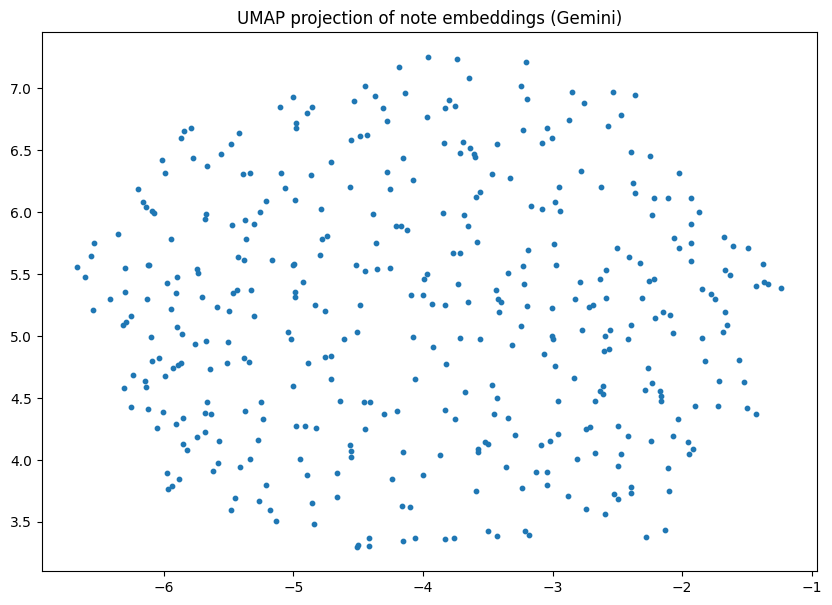

,timestamp,tags,topic,umap_x,umap_y
note_id,,,,,
60cecc51-4de7-4b99-9255-969b138e3a1c,2025-03-02 09:58:48.016101,meeting,habit-tracking,-2.588284,5.303926
5c08fa2a-f2a9-4089-bc4a-0f561bfd80e3,2025-03-02 12:09:25.016101,reading,product-vision,-4.123204,5.856144
6b7a4d0d-6ef6-4f0b-bc61-927b52a3c3c2,2025-03-04 09:01:51.016101,"idea,writing",experiments,-2.061685,5.795352
cad275af-45bb-4c1d-8b18-ca4ea28b8841,2025-03-05 09:46:32.016101,"ops,personal",habit-tracking,-6.129491,5.299922
ca8055f1-1b79-40d1-9297-c0c90a907f5e,2025-03-06 05:36:51.016101,"idea,personal,product",literature-review,-5.466430,5.345440


In [60]:
# ==== Embeddings with Gemini + Graph Construction ====
 
notes_df["timestamp"] = pd.to_datetime(notes_df["timestamp"])
notes_df["content_short"] = notes_df["title"].fillna('') + ". " + notes_df["content"].fillna('')
 
texts = notes_df["content_short"].tolist()
 
def embed_texts_with_gemini(text_list, model_name=EMBED_MODEL, batch_size=32):
    """Use Gemini embeddings API to embed a list of texts."""
    all_embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Embedding notes with Gemini"):
        batch = text_list[i:i+batch_size]
        try :
            result = client.models.embed_content(
            model=model_name,
            contents=batch,
            config=types.EmbedContentConfig(
                task_type="retrieval_document",
            ),
        )
        # result.embedding is a list of vectors (for list input)
            if 'embedding' in result:
                batch_embs = [e.values for e in result['embedding']]
            else:
                batch_embs = [e.values for e in result.embeddings]
            all_embeddings.extend(batch_embs)
        except Exception as e:
            print(f"Error embeddingf batch {i}: {e}")
            all_embeddings.extend([np.zeros(768) for _ in batch])
    return np.array(all_embeddings, dtype="float32")
 
emb_matrix = embed_texts_with_gemini(texts)
emb_matrix = normalize(emb_matrix)
 
print("Embedding matrix shape:", emb_matrix.shape)
 
# Mapping note_id <-> embedding index
note_id_to_idx = {nid: i for i, nid in enumerate(notes_df["note_id"])}
idx_to_note_id = {i: nid for nid, i in note_id_to_idx.items()}
 
# Full cosine similarity matrix
sim_matrix = cosine_similarity(emb_matrix)
print("sim_matrix shape:", sim_matrix.shape)
 
# Build NetworkX graph
G = nx.Graph()
 
# Add note nodes
for _, row in notes_df.iterrows():
    nid = f"note:{row['note_id']}"
    G.add_node(
        nid,
        node_type="note",
        title=row["title"],
        content=row["content"],
        tags=row["tags"],
        topic=row["topic"],
        context=row["context"],
        timestamp=row["timestamp"],
        source=row["source"]
    )
 
# Add semantic edges (top-K neighbors beyond threshold)
TOP_K = 6
SIM_THRESHOLD = 0.55
 
for i in range(len(notes_df)):
    nid_i = notes_df.loc[i, "note_id"]
    src_key = f"note:{nid_i}"
    sims = sim_matrix[i]
    neighbor_idx = np.argsort(-sims)[: TOP_K + 1]  # includes self
 
    for j in neighbor_idx:
        if j == i:
            continue
        score = float(sims[j])
        if score < SIM_THRESHOLD:
            continue
        nid_j = idx_to_note_id[j]
        dst_key = f"note:{nid_j}"
 
        if G.has_edge(src_key, dst_key):
            if score > G[src_key][dst_key].get("weight", 0):
                G[src_key][dst_key]["weight"] = score
                G[src_key][dst_key]["type"] = "semantic"
        else:
            G.add_edge(src_key, dst_key, type="semantic", weight=score)
 
# Add tag nodes & edges
for _, row in notes_df.iterrows():
    nid = f"note:{row['note_id']}"
    tags_str = row.get("tags", "")
    if pd.isna(tags_str) or str(tags_str).strip() == "":
        continue
    for t in str(tags_str).split(","):
        t = t.strip()
        if not t:
            continue
        tid = f"tag:{t}"
        if not G.has_node(tid):
            G.add_node(tid, node_type="tag", tag=t)
        G.add_edge(nid, tid, type="shares_tag")
 
# Add simple temporal edges: notes within 3 days of each other (sliding window)
notes_ts = notes_df[["note_id", "timestamp"]].dropna().sort_values("timestamp").reset_index(drop=True)
 
for i in range(len(notes_ts)):
    for j in range(i + 1, min(i + 4, len(notes_ts))):
        t1 = notes_ts.loc[i, "timestamp"]
        t2 = notes_ts.loc[j, "timestamp"]
        if abs((t2 - t1).days) <= 3:
            n1 = f"note:{notes_ts.loc[i, 'note_id']}"
            n2 = f"note:{notes_ts.loc[j, 'note_id']}"
            if not G.has_edge(n1, n2):
                G.add_edge(n1, n2, type="created_near", weight=0.2)
 
# Interactions to mark revisits / last interaction
interactions_df["timestamp"] = pd.to_datetime(interactions_df["timestamp"])
for _, r in interactions_df.iterrows():
    itype = r["type"]
    target = r["target_id"]
    if not target:
        continue
    if target in note_id_to_idx:
        nid = f"note:{target}"
        if nid not in G:
            continue
        if itype == "revisit_old_note":
            G.nodes[nid]["revisited"] = G.nodes[nid].get("revisited", 0) + 1
        if itype in ["open_note", "edit_note", "add_new_note"]:
            G.nodes[nid]["last_interaction"] = r["timestamp"]
 
print("Graph nodes:", G.number_of_nodes())
print("Graph edges:", G.number_of_edges())
 
# UMAP projection
reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
emb_2d = reducer.fit_transform(emb_matrix)
notes_df["umap_x"] = emb_2d[:, 0]
notes_df["umap_y"] = emb_2d[:, 1]
 
plt.scatter(notes_df["umap_x"], notes_df["umap_y"], s=10)
plt.title("UMAP projection of note embeddings (Gemini)")
plt.show()
 
notes_meta = notes_df.set_index("note_id")[["timestamp", "tags", "topic", "umap_x", "umap_y"]]
notes_meta.head()

## Non-LLM Insight Engine on PKG
 
We now build the Insight Engine that runs on the PKG + embeddings:
 
1. **Novel Connections** – new notes that are semantically similar to graph-distant notes.
2. **Resurrections** – old notes (120+ days) that suddenly get many strong links from recent notes.
3. **Topic Drift** – how the centroid of note embeddings shifts over time windows.

In [61]:
# ==== Insight Engine – Rules ====
 
def now_iso():
    return datetime.utcnow().isoformat()
 
def make_insight(insight_type, payload, score, evidence, severity="medium", tags=None, explanation=""):
    return {
        "insight_id": str(uuid.uuid4()),
        "type": insight_type,
        "timestamp": now_iso(),
        "score": float(score),
        "severity": severity,
        "payload": payload,
        "evidence": evidence,
        "tags": tags or [],
        "explanation": explanation
    }
 
# Cluster notes in embedding space
k = min(10, max(2, len(notes_df) // 40))
km = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(emb_matrix)
notes_df["cluster"] = km.labels_
 
node_to_cluster = {}
for _, row in notes_df.iterrows():
    nid = f"note:{row['note_id']}"
    if nid in G:
        G.nodes[nid]["cluster"] = int(row["cluster"])
        node_to_cluster[nid] = int(row["cluster"])
 
deg_centrality = nx.degree_centrality(G)
 
def bounded_graph_distance(u, v, cutoff=6):
    try:
        d = nx.shortest_path_length(G, source=u, target=v)
        return d
    except Exception:
        return math.inf
 
NOVEL_CONNECT_SIM_THRESHOLD = 0.62
NOVEL_CONNECT_GRAPH_HOP = 3
RESURRECTION_OLD_DAYS = 120
RESURRECTION_RECENT_DAYS = 30
RESURRECTION_MIN_NEW_LINKS = 3
DRIFT_WINDOW_DAYS = 60
DRIFT_MIN_NOTE_COUNT = 15
 
# --- Rule 1: Novel Connection ---
novel_insights = []
 
recent_window_days = 45
cutoff_recent = datetime.utcnow() - pd.Timedelta(days=recent_window_days)
 
recent_note_ids = [
    nid for nid, row in notes_meta.iterrows()
    if pd.notna(row["timestamp"]) and row["timestamp"] >= cutoff_recent
]
 
if len(recent_note_ids) == 0:
    recent_note_ids = notes_meta.sort_values("timestamp").tail(max(10, int(0.1 * len(notes_meta)))).index.tolist()
 
for nid in tqdm(recent_note_ids, desc="Novel connection candidates"):
    node_key = f"note:{nid}"
    if node_key not in G:
        continue
    idx = note_id_to_idx.get(nid)
    if idx is None:
        continue
 
    sims = sim_matrix[idx]
    cand_idx = np.argsort(-sims)[:50]
 
    for j in cand_idx:
        if j == idx:
            continue
        sim_score = float(sims[j])
        if sim_score < NOVEL_CONNECT_SIM_THRESHOLD:
            continue
 
        other_nid = idx_to_note_id[j]
        node_other_key = f"note:{other_nid}"
        if node_other_key not in G:
            continue
 
        gdist = bounded_graph_distance(node_key, node_other_key, cutoff=NOVEL_CONNECT_GRAPH_HOP)
        if gdist < NOVEL_CONNECT_GRAPH_HOP:
            continue
 
        c1 = node_to_cluster.get(node_key, -1)
        c2 = node_to_cluster.get(node_other_key, -1)
        cluster_factor = 1.0 if c1 != c2 else 0.6
 
        cent = deg_centrality.get(node_other_key, 0.0)
        cent_factor = 0.5 + 0.5 * cent
 
        score = sim_score * (gdist / (gdist + 1)) * cluster_factor * cent_factor
 
        src_title = G.nodes[node_key].get("title", "")[:80]
        dst_title = G.nodes[node_other_key].get("title", "")[:80]
 
        explanation = (
            f"Recent note '{src_title}' (id={nid}) is semantically similar (sim={sim_score:.2f}) "
            f"to distant note '{dst_title}' (id={other_nid}).\n"
            f"Graph distance is {gdist}, suggesting they sit in different regions of your PKG."
        )
 
        payload = {
            "source_note": nid,
            "target_note": other_nid,
            "sim": sim_score,
            "graph_distance": gdist
        }
        evidence = {"source_title": src_title, "target_title": dst_title}
        severity = "high" if score > 0.6 else "medium"
 
        novel_insights.append(
            make_insight(
                "novel_connection",
                payload,
                score,
                evidence,
                severity=severity,
                tags=["novel", "connection"],
                explanation=explanation
            )
        )
 
novel_insights = sorted(novel_insights, key=lambda x: -x["score"])[:150]
print("Novel insights:", len(novel_insights))
 
 
# --- Rule 2: Resurrection ---
resurrection_insights = []
 
now = datetime.utcnow()
old_cutoff = now - pd.Timedelta(days=RESURRECTION_OLD_DAYS)
recent_cutoff = now - pd.Timedelta(days=RESURRECTION_RECENT_DAYS)
 
note_timestamps = notes_meta["timestamp"].to_dict()
 
recent_note_ids_all = [
    nid for nid, row in notes_meta.iterrows()
    if pd.notna(row["timestamp"]) and row["timestamp"] >= recent_cutoff
]
recent_idxs_all = [note_id_to_idx[nid] for nid in recent_note_ids_all if nid in note_id_to_idx]
 
for nid, ts in tqdm(note_timestamps.items(), desc="Resurrection candidates"):
    if pd.isna(ts) or ts >= old_cutoff:
        continue
 
    idx_old = note_id_to_idx.get(nid)
    if idx_old is None or not recent_idxs_all:
        continue
 
    sims = cosine_similarity(
        emb_matrix[idx_old:idx_old + 1],
        emb_matrix[recent_idxs_all]
    )[0]
 
    strong_links = [recent_note_ids_all[i] for i, s in enumerate(sims) if s >= NOVEL_CONNECT_SIM_THRESHOLD]
    if len(strong_links) < RESURRECTION_MIN_NEW_LINKS:
        continue
 
    strong_sims = [s for s in sims if s >= NOVEL_CONNECT_SIM_THRESHOLD]
    avg_sim = float(np.mean(strong_sims))
    count = len(strong_links)
 
    ages = [
        (now - notes_meta.loc[rid, "timestamp"]).days
        for rid in strong_links
        if pd.notna(notes_meta.loc[rid, "timestamp"])
    ]
    avg_age = float(np.mean(ages)) if ages else RESURRECTION_RECENT_DAYS
    recency_factor = max(0.2, 1.0 - (avg_age / RESURRECTION_RECENT_DAYS))
 
    score = (count * avg_sim) * recency_factor
 
    old_title = G.nodes.get(f"note:{nid}", {}).get("title", "")[:120]
    explanation = (
        f"Old note '{old_title}' (created {ts.date()}) now has {count} strong semantic links "
        f"(avg sim={avg_sim:.2f}) to notes created in the last {RESURRECTION_RECENT_DAYS} days."
    )
 
    payload = {
        "old_note": nid,
        "new_links_count": count,
        "avg_sim": avg_sim
    }
    evidence = {
        "old_title": old_title,
        "linked_recent_notes": strong_links
    }
    severity = "high" if score > 1.5 else "medium"
 
    resurrection_insights.append(
        make_insight(
            "resurrection",
            payload,
            score,
            evidence,
            severity=severity,
            tags=["resurrection", "revival"],
            explanation=explanation
        )
    )
 
resurrection_insights = sorted(resurrection_insights, key=lambda x: -x["score"])[:100]
print("Resurrection insights:", len(resurrection_insights))
 
 
# --- Rule 3: Topic Drift ---
drift_insights = []
 
notes_meta_reset = notes_meta.reset_index()
notes_meta_reset["ts"] = pd.to_datetime(notes_meta_reset["timestamp"])
notes_meta_reset = notes_meta_reset.dropna(subset=["ts"]).sort_values("ts")
 
if len(notes_meta_reset) < DRIFT_MIN_NOTE_COUNT:
    print("Not enough notes for drift detection.")
else:
    start_time = notes_meta_reset["ts"].min()
    end_time = notes_meta_reset["ts"].max()
 
    windows = []
    t = start_time
    while t < end_time:
        wstart = t
        wend = t + pd.Timedelta(days=DRIFT_WINDOW_DAYS)
        windows.append((wstart, wend))
        t = t + pd.Timedelta(days=DRIFT_WINDOW_DAYS // 2)
 
    window_centroids = []
    window_note_ids = []
 
    for wstart, wend in windows:
        mask = (notes_meta_reset["ts"] >= wstart) & (notes_meta_reset["ts"] < wend)
        subset = notes_meta_reset[mask]
        if len(subset) < 5:
            window_centroids.append(None)
            window_note_ids.append([])
            continue
 
        idxs = [note_id_to_idx[nid] for nid in subset["note_id"] if nid in note_id_to_idx]
        if not idxs:
            window_centroids.append(None)
            window_note_ids.append([])
            continue
 
        centroid = np.mean(emb_matrix[idxs], axis=0)
        centroid = centroid / np.linalg.norm(centroid)
        window_centroids.append(centroid)
        window_note_ids.append([nid for nid in subset["note_id"] if nid in note_id_to_idx])
 
    for i in range(1, len(window_centroids)):
        c_prev = window_centroids[i - 1]
        c_curr = window_centroids[i]
        if c_prev is None or c_curr is None:
            continue
 
        cos = float(np.dot(c_prev, c_curr) / (np.linalg.norm(c_prev) * np.linalg.norm(c_curr)))
        dist = 1.0 - cos
 
        prev_notes = window_note_ids[i - 1]
        curr_notes = window_note_ids[i]
 
        prev_tags = Counter()
        curr_tags = Counter()
 
        for nid in prev_notes:
            tags_str = G.nodes.get(f"note:{nid}", {}).get("tags", "")
            for t in str(tags_str).split(","):
                t = t.strip()
                if t:
                    prev_tags[t] += 1
 
        for nid in curr_notes:
            tags_str = G.nodes.get(f"note:{nid}", {}).get("tags", "")
            for t in str(tags_str).split(","):
                t = t.strip()
                if t:
                    curr_tags[t] += 1
 
        top_prev = set([t for t, _ in prev_tags.most_common(3)])
        top_curr = set([t for t, _ in curr_tags.most_common(3)])
 
        added = list(top_curr - top_prev)
        removed = list(top_prev - top_curr)
 
        score = dist * math.log(1 + len(curr_notes))
 
        if score > 0.02:
            explanation = (
                f"Between {windows[i-1][0].date()} and {windows[i][1].date()}, "
                f"your note centroid shifted (cosine distance={dist:.3f}). "
                f"New focus tags: {added}. Reduced tags: {removed}."
            )
 
            payload = {
                "window_index": i,
                "distance": dist,
                "added_tags": added,
                "removed_tags": removed,
                "prev_count": len(prev_notes),
                "curr_count": len(curr_notes)
            }
            evidence = {
                "prev_window_start": str(windows[i-1][0]),
                "prev_window_end": str(windows[i-1][1]),
                "curr_window_start": str(windows[i][0]),
                "curr_window_end": str(windows[i][1])
            }
            severity = "high" if score > 0.2 else "medium"
 
            drift_insights.append(
                make_insight(
                    "topic_drift",
                    payload,
                    score,
                    evidence,
                    severity=severity,
                    tags=["drift", "topic"],
                    explanation=explanation
                )
            )
 
    print("Topic drift insights:", len(drift_insights))
 
all_insights = novel_insights + resurrection_insights + drift_insights
print("Total insights:", len(all_insights))

Novel connection candidates: 100%|██████████| 56/56 [00:00<00:00, 600.66it/s]


Novel insights: 150


Resurrection candidates: 100%|██████████| 400/400 [00:00<00:00, 583.29it/s]

Resurrection insights: 100
Topic drift insights: 0
Total insights: 250


## Gemini Reflection Agent
 
We now add a **Gemini-powered Reflection Agent**:
 
- Input: structured insight (JSON dict)
- Output: natural-language explanation + 2–3 suggested next steps
- Style: calm, reflective, “second brain” tone

In [62]:
def enrich_insight_with_gemini(insight):
    prompt = f"""
You are Notee, a calm, reflective "second brain" assistant.
 
You are given ONE insight object as JSON from a knowledge-graph insight engine.
Your tasks:
 
1. Briefly explain (in 2–4 sentences) what this insight means for the user.
2. Suggest 2–3 concrete next steps or reflection prompts for the user.
3. Be gentle, thoughtful, non-judgmental.
4. Do NOT restate the raw JSON; interpret it.
5. Assume the user is a knowledge worker / learner / builder.
 
Insight JSON:
{json.dumps(insight, indent=2)}
 
Respond in this format:
 
Explanation:
- <2–4 sentence explanation>
 
Suggested next steps:
- <step 1>
- <step 2>
- <step 3>
""".strip()
 
    try:
        response = client.models.generate_content(
            model= GEN_MODEL,
            contents=prompt)
        text = response.text.strip()
    except Exception as e:
        text = f"[Gemini error: {e}]"
 
    enriched = dict(insight)
    enriched["llm_reflection"] = text
    return enriched
 
 
# Enrich top N insights
N_GEMINI = 5
top_insights = sorted(all_insights, key=lambda x: -x["score"])[:N_GEMINI]
 
enriched_insights = [enrich_insight_with_gemini(ins) for ins in top_insights]
 
for ins in enriched_insights:
    print("\n========================================")
    print("Insight Type:", ins["type"], "| Score:", round(ins["score"], 3), "| Severity:", ins["severity"])
    print("Payload:", ins["payload"])
    print("\nGemini Reflection:\n")
    print(ins["llm_reflection"])


Insight Type: resurrection | Score: 12.596 | Severity: high
Payload: {'old_note': '1392315a-8826-41b5-9aa0-449b8a65acde', 'new_links_count': 40, 'avg_sim': 0.8849361538887024}

Gemini Reflection:

Explanation:
- It seems an older note, titled "Second sell mouth here relationship listen certain," has become highly relevant again. This note, which might have been dormant, is now strongly connected to a significant number of your recent notes. It's possible that a theme or idea you explored previously is resurfacing in your current work.

Suggested next steps:
- Revisit the old note ("Second sell mouth here relationship listen certain") to understand why it's suddenly so relevant.
- Explore the connections between the old note and the new notes to identify emerging patterns or insights.
- Consider if this "resurrection" indicates a recurring theme in your thinking or a project that deserves renewed attention.

Insight Type: resurrection | Score: 12.583 | Severity: high
Payload: {'old_not

## RAG Question Answering over Notes (Gemini Embeddings)
 
We implement a small **RAG pipeline**:
 
1. Embed the user query using the **same Gemini embedding model**.
2. Compute cosine similarity with note embeddings.
3. Select top-K notes as context.
4. Ask Gemini to answer using only these notes as the "second brain".

In [63]:
def retrieve_relevant_notes(query, top_k=5):
    """Retrieve top_k most relevant notes for a query using Gemini embeddings."""
    result = client.models.embed_content(
        model=EMBED_MODEL,
        contents=query,
        config=types.EmbedContentConfig(
                task_type="retrieval_query",
            ),
    )
    q_emb = np.array(result.embeddings[0].values, dtype="float32").reshape(1, -1)
    q_emb = normalize(q_emb)
 
    sims = cosine_similarity(q_emb, emb_matrix)[0]
    idxs = np.argsort(-sims)[:top_k]
    results = []
    for idx in idxs:
        nid = idx_to_note_id[idx]
        row = notes_df.loc[note_id_to_idx[nid]]
        results.append({
            "note_id": nid,
            "score": float(sims[idx]),
            "title": row["title"],
            "content": row["content"]
        })
    return results
 
def answer_question_with_notes(query, top_k=5):
    context_notes = retrieve_relevant_notes(query, top_k=top_k)
 
    context_str = "\n\n".join(
        [f"[Note {i+1} | score={n['score']:.3f}] {n['title']}\n{n['content']}"
         for i, n in enumerate(context_notes)]
    )
 
    prompt = f"""
You are Notee, a personal "second brain" agent.
 
The user has asked:
\"\"\"{query}\"\"\".
 
Here is a set of their own notes that might be relevant:
 
{context_str}
 
Using ONLY the information in these notes (plus reasonable general reasoning),
please:
 
1. Answer the user's question as clearly as possible.
2. If the notes are weak or tangential, say so gently and suggest how they might capture better notes next time.
 
Respond in 1–3 short paragraphs.
""".strip()
 
    response = client.models.generate_content(
            model= GEN_MODEL,
            contents=prompt)
    return response.text, context_notes
 
# Example demo (replace the question with any text you like)
demo_question = "What patterns can I see about my growth and experiments?"
answer, used_notes = answer_question_with_notes(demo_question, top_k=5)
 
print("Question:", demo_question)
print("\nAnswer:\n", answer)
 
print("\nContext note titles used:")
for n in used_notes:
    print("-", n["title"], f"(score={n['score']:.3f})")

Question: What patterns can I see about my growth and experiments?

Answer:
 Based on your notes, some patterns around growth and experiments include:

*   **Career/Skills:** You mention skills that "indicate chance heavy" (Note 1), potentially suggesting you've been experimenting with skills-based activities that rely on chance. "Scientist" appears in multiple notes (1 & 3), possibly showing consistent interest or activity in scientific fields. "Training", "develop", and "teach" (Note 4) also suggest experiments in self-improvement.
*   **Environment:** "Environmental purpose" (Note 1), "wind kitchen" (Note 3), and "glass star" (Note 4) indicate different aspects of the environment you are interested in.
*   **Production and Technology:** "Memory production successful hear" (Note 3) hints at efforts to understand memory and possibly experiment with productivity techniques and possibly technology.

The notes are somewhat fragmented and don't provide a clear picture. To capture better n

## Function-Calling Agent with Gemini
 
Now we show **automatic function calling**:
 
- We define a Python function `search_notes_tool(query: str, top_k: int = 5)` that:
  - Runs vector search over notes
  - Returns a compact JSON string of relevant notes
- We give this as a **tool** to Gemini.
- Gemini decides when to call it while answering the user.

In [64]:
def search_notes_tool(query: str, top_k: int = 5) -> str:
    """
    Tool function for Gemini function-calling.
    Returns a JSON string with the top_k notes retrieved for the query.
    """
    results = retrieve_relevant_notes(query, top_k=top_k)
    compact = [
        {
            "note_id": r["note_id"],
            "score": r["score"],
            "title": r["title"],
            "snippet": r["content"][:240]
        }
        for r in results
    ]
    return json.dumps(compact)
 
tool_model = genai.GenerativeModel(
    model_name=GEN_MODEL,
    tools=[search_notes_tool]
)
 
fc_prompt = """
You are Notee, a second brain agent.
 
The user will ask for help. If their question seems to require inspecting
their existing notes, you should CALL the `search_notes_tool` function
with an appropriate query to fetch relevant notes, then answer using
the returned results.
 
User: I'm trying to remember what I was exploring about agents and habits. Can you remind me and suggest how to continue?
"""
 
fc_response = tool_model.generate_content(fc_prompt)
 
print(fc_response.text)

AttributeError: module 'google.genai' has no attribute 'GenerativeModel'